# PUMA Dataset Sampling
Devise a method to pull sample from the PUMS dataset that is proportional (temporally) to respondents of the CMAP Survey.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame
from shapely import Point
from pathlib import Path

epsg = "EPSG:4326"
# data_folder = Path("../synth-survey-gen/data")
data_folder = Path("../data")

pums_person = pd.read_csv(data_folder / "MyDailyTravelData/person.csv", low_memory=False)
pums_location = pd.read_csv(data_folder / "MyDailyTravelData/location.csv")

puma_gdf = gpd.read_file(data_folder / "puma/ipums_puma_2010.shp")
puma_gdf = puma_gdf.to_crs(epsg)

Get GeoDataFrame of household locations and the number of people in that household.

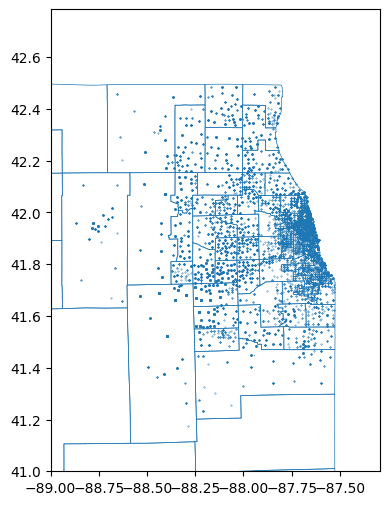

In [2]:
# get number of people in each household based on "sampno" the household identifier
household_size = pums_person[["sampno", "perno"]].groupby(by="sampno")["perno"].max()

# get location of each household as GeoDataFrame
household_locations = pums_location[pums_location.loctype==1] \
    .drop_duplicates(subset="sampno") \
    .set_index("sampno")[["latitude", "longitude"]]
household_locations = household_locations.join(household_size)
geometry = household_locations.apply(
    lambda row: Point(row.longitude, row.latitude), axis=1
    )
household_gdf = GeoDataFrame(household_locations, geometry=geometry, crs=epsg)

fig, ax = plt.subplots(figsize=(6,6), dpi=100)
puma_gdf[puma_gdf.State=="Illinois"].boundary.plot(ax=ax, linewidth=0.5)
household_gdf.plot(markersize=0.1, ax=ax, marker="o")
plt.ylim(bottom = 41.00)
plt.xlim(left = -89.00)
plt.show()
# plt.plot()

In [3]:
household_size.head()

sampno
20000083    1
20000136    3
20000228    1
20000248    3
20000300    1
Name: perno, dtype: int64

Spatial join PUMA areas to household locations


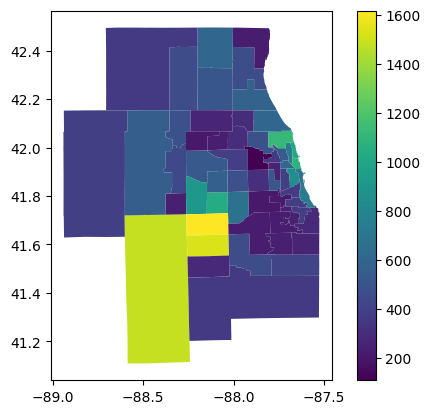

In [4]:
# get count of households in each PUMA zone
household_join = household_gdf.sjoin(puma_gdf, predicate="within")
household_puma_counts = household_join.groupby(by=["PUMA"])["perno"].sum()

# join household counts to puma_gdf
puma_gdf_il = puma_gdf[puma_gdf.State=="Illinois"]
puma_household_counts = puma_gdf_il.set_index("PUMA").join(household_puma_counts, how = "inner")[["GEOID", "Name", "perno", "geometry"]]

puma_household_counts.plot(column="perno", legend=True)
plt.show()

In [ ]:
puma_household_counts.PUMA

In [65]:
persons = pd.read_csv("../synth-survey-gen/configs/pums_cmap/data/psam_p17.csv")
n = 3068
samples = []
seed = 0
puma_household_counts["sample_weight"] = puma_household_counts.perno / puma_household_counts.perno.sum()
for _, row in puma_household_counts.iterrows():
    puma = row.PUMA
    weight = row.sample_weight

    sample = persons[persons.PUMA==puma].sample(int(weight*n), random_state=seed)
    samples.append(sample)
person_sample = pd.concat(samples)
person_sample

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
81988,P,2019HU0905764,3,2,3310,2,17,1010145,119,47,...,34,118,107,133,150,37,134,34,131,138
34376,P,2019HU0343685,3,1,3310,2,17,1010145,45,46,...,76,77,15,47,40,73,12,40,49,68
70417,P,2019HU0768257,3,1,3310,2,17,1010145,95,48,...,172,161,169,29,80,95,160,27,91,27
64296,P,2019HU0696754,3,1,3310,2,17,1010145,37,64,...,34,61,37,12,10,37,38,11,63,34
83205,P,2019HU0920705,3,2,3310,2,17,1010145,119,73,...,120,101,35,113,191,115,207,177,38,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38879,P,2019HU0397670,3,2,3416,2,17,1010145,78,64,...,140,21,82,76,78,132,23,72,74,22
18335,P,2019HU0154315,3,1,3416,2,17,1010145,62,71,...,19,58,100,63,105,112,20,69,17,62
47734,P,2019HU0499966,3,4,3416,2,17,1010145,75,1,...,26,119,128,76,79,78,22,71,120,72
48002,P,2019HU0502782,3,2,3416,2,17,1010145,71,35,...,72,66,80,21,72,70,74,126,69,122


Get household to puma and puma to perno

In [66]:
grouped_persons = person_sample.groupby("PUMA")["RT"].count()
grouped_persons

PUMA
2601     38
3005     24
3007     43
3008     48
3009     55
3102     28
3105    153
3106    161
3107     45
3108     36
3202     56
3203    103
3204     67
3205     47
3207     38
3208     52
3209     91
3306     60
3307     22
3308     51
3309     45
3310     58
3401     26
3407     31
3408     51
3409     20
3410     22
3411     22
3412     24
3413     25
3414     41
3415     29
3416     59
3417     20
3418     23
3419     29
3420     48
3421    111
3422     10
3501    100
3502    108
3503     73
3504     53
3520     34
3521     25
3522     60
3523     39
3524     84
3525     66
3526     37
3527     21
3528     37
3529     73
3530     24
3531     37
3532     28
3601     35
3602     45
3700    148
Name: RT, dtype: int64

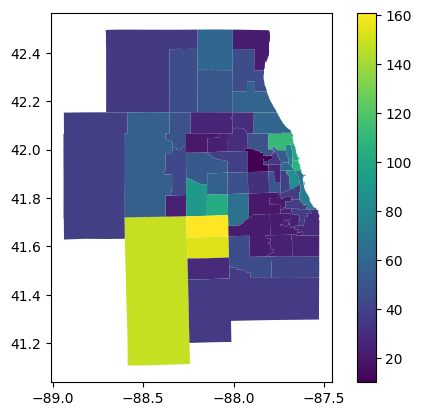

In [68]:
pd.merge(puma_household_counts, grouped_persons, on="PUMA").plot(column="RT", legend=True)
plt.show()